In [59]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow import keras
import tensorflow as tf

from joblib import Parallel, delayed

np.set_printoptions(suppress=True, precision=6)
pd.set_option('display.float_format', '{:.6f}'.format)

In [60]:
df = pd.read_csv("data/otu_table_example.csv", index_col="Unnamed: 0").T

In [61]:
print(df.head())

             1050608  130468   3589405  355102   1081058  189592   354275   \
E000823.1.8        0        0        0        0        0        0        0   
E000823.2.6        0        0        0        0        0        0        0   
E000823.4.0        0        0        0        0        0        0        0   
E000823.5.0        0        0        0        0        0        0        0   
E000823.5.7        0        0        0        0        0        0        0   

             4327628  326749   183857   ...  317924   4294457  2655741  \
E000823.1.8        0        0        0  ...        0        0        0   
E000823.2.6        0        0        0  ...        0        0        0   
E000823.4.0        0        0        0  ...        0        0        0   
E000823.5.0        0        0        0  ...        0        0        0   
E000823.5.7        0        0        0  ...        0        0        0   

             858535   186092   299820   225846   4306049  366846   1124370  
E000823.1

In [62]:
# get rid of features that are way too sparse
zero_values_percentage_cutoff = .9

zero_counts = pd.Series([sum(df[col] == 0) for col in df.columns], index=df.columns)
zero_pcts = zero_counts / len(df)
populated_feats = zero_pcts[zero_pcts < zero_values_percentage_cutoff].index
df = df[populated_feats]

In [63]:
df

,189592,183857,4343580,198956,177319,505587,194104,193778,362389,2017729,...,368462,356360,183438,365385,178849,580008,296945,267718,354850,317924
E000823.1.8,0,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,7,0
E000823.2.6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
E000823.4.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,4,0,0,0,0,4,0
E000823.5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
E000823.5.7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,1,0,4,0,13,0,6,0,1,0,...,0,0,0,1,0,446,0,5,7,1
E014086.32.4,0,0,0,0,44,0,16,0,0,3,...,0,4,0,0,0,851,0,3,50,1
E014086.33.5,0,0,3,0,11,0,11,0,0,2,...,0,3,0,0,0,664,0,3,46,1
E014086.34.4,1,0,1,0,9,0,9,0,0,0,...,0,1,0,0,0,180,0,3,28,0


In [64]:
def forward_rolling_average(series, window_size):
    
    original_idxs = series.index
    
    series = series.reset_index(drop=True)
    
    for idx in range(len(series) - window_size):
       
        next_vals = series[idx+1:idx+window_size+1]
        
        #print(idx, next_vals.tolist())
        
        series[idx] = next_vals.mean()
    
    series.index = original_idxs
    
    series = series.iloc[:-window_size]
            
    return series
    

In [65]:
window_size = 3
sequence = pd.Series([0,1,2,3,4,5,6,7,8,9,10])

forward_rolling_average(sequence, window_size)

0    2
1    3
2    4
3    5
4    6
5    7
6    8
7    9
dtype: int64

In [66]:
#def smooth_it_out(df, rolling_window=5):
#    # Define the window size for the rolling average
#    window_size = 5
#    
#    # Apply rolling mean to numeric columns
#    df = df.shift(-window_size + 1).rolling(window=window_size).mean()
#    
#    return df

In [67]:
def smooth_it_out(df, window_size=5, n_jobs=32):
    
    smooth_cols = Parallel(n_jobs=-n_jobs)(delayed(forward_rolling_average)(df[col], window_size) for col in df.columns)
    
    for idx, col in enumerate(df.columns):
        df[col] = smooth_cols[idx]
    
    return df

In [68]:
def feature_wise_scaling(df):
    for col in df.columns:
        _min_ = df[col].min()
        _max_ = df[col].max()
        
        df[col] = (df[col] - _min_) / (_max_ - _min_)
        
    return df      

In [69]:
def preprocess(feats_df, seq_length):
    num_features = len(feats_df.columns)
    
    X_sequences = []
    y_targets = []
    
    for i in range(len(feats_df) - seq_length):
        X_sequences.append(feats_df.iloc[i:i+seq_length])
        y_targets.append(feats_df.iloc[i+seq_length])
    
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    X_sequences = X_sequences.reshape(-1, seq_length, num_features)
    
    return X_sequences, y_targets

In [70]:
def mae_ignore_zeros(y_true, y_pred, false_positives_penalty_factor=0.5):
    
    # Find indices where y_true is not zero
    non_zero_indices = tf.where(tf.not_equal(y_true, 0))
    
    # Gather the non-zero elements from y_true and y_pred using the indices
    y_true_non_zero = tf.gather_nd(y_true, non_zero_indices)
    y_pred_non_zero = tf.gather_nd(y_pred, non_zero_indices)
    
    y_true_non_zero = tf.cast(y_true_non_zero, tf.float64)
    y_pred_non_zero = tf.cast(y_pred_non_zero, tf.float64)
    
    # Calculate MAE on the non-zero elements
    mae_non_zero = tf.reduce_mean(tf.abs(y_pred_non_zero - y_true_non_zero))
    
    # Find indices where y_true is zero 
    zero_indices = tf.where(tf.equal(y_true, 0))
    
    # Gather the corresponding y_pred values
    y_pred_zero = tf.gather_nd(y_pred, zero_indices)
    
    y_pred_zero = tf.cast(y_pred_zero, tf.float64)
    
    # Calculate the average of false positives
    false_positives_avg = tf.reduce_mean(y_pred_zero)
    
    # Combine the MAE on non-zero elements with the average of false positives
    mae_ignore_zeros = mae_non_zero + (false_positives_avg * false_positives_penalty_factor)
    
    return mae_ignore_zeros

In [71]:
y_true = [0,0,10]
y_pred = [0,0,0]

keras.losses.mae(y_true, y_pred)

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [72]:
mae_ignore_zeros(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=10.0>

In [73]:
df = smooth_it_out(df=df, window_size=5)
df

,189592,183857,4343580,198956,177319,505587,194104,193778,362389,2017729,...,368462,356360,183438,365385,178849,580008,296945,267718,354850,317924
E000823.1.8,0.000000,0.200000,0.200000,0.000000,0.000000,0.600000,0.000000,0.000000,0.400000,0.000000,...,0.200000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.200000,0.000000
E000823.2.6,0.000000,0.200000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.400000,0.000000,...,0.200000,0.000000,0.000000,1.800000,0.000000,0.000000,0.000000,0.000000,0.800000,0.000000
E000823.4.0,0.000000,0.400000,0.200000,0.000000,0.000000,0.600000,0.000000,0.000000,0.400000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E000823.5.0,0.200000,0.600000,0.200000,0.000000,2.600000,0.600000,8.400000,0.000000,1.000000,0.200000,...,0.600000,0.000000,0.800000,13.800000,0.000000,0.000000,0.000000,0.000000,0.800000,0.400000
E000823.5.7,0.200000,0.600000,0.200000,0.000000,3.600000,0.800000,11.000000,0.000000,1.600000,0.200000,...,0.800000,0.400000,0.800000,45.600000,0.000000,0.400000,0.000000,0.000000,1.200000,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.32.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.34.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df = feature_wise_scaling(df)
df

,189592,183857,4343580,198956,177319,505587,194104,193778,362389,2017729,...,368462,356360,183438,365385,178849,580008,296945,267718,354850,317924
E000823.1.8,0.000000,0.055556,0.028571,0.000000,0.000000,0.007979,0.000000,0.000000,0.048780,0.000000,...,0.007407,0.000000,0.000000,0.000848,0.000000,0.000000,0.000000,0.000000,0.019934,0.000000
E000823.2.6,0.000000,0.055556,0.000000,0.000000,0.000000,0.007979,0.000000,0.000000,0.048780,0.000000,...,0.007407,0.000000,0.000000,0.000763,0.000000,0.000000,0.000000,0.000000,0.013289,0.000000
E000823.4.0,0.000000,0.111111,0.028571,0.000000,0.000000,0.007979,0.000000,0.000000,0.048780,0.000000,...,0.000000,0.000000,0.000000,0.000424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E000823.5.0,0.002538,0.166667,0.028571,0.000000,0.151163,0.007979,0.330709,0.000000,0.121951,0.076923,...,0.022222,0.000000,0.181818,0.005852,0.000000,0.000000,0.000000,0.000000,0.013289,0.166667
E000823.5.7,0.002538,0.166667,0.028571,0.000000,0.209302,0.010638,0.433071,0.000000,0.195122,0.076923,...,0.029630,0.055556,0.181818,0.019337,0.000000,0.000142,0.000000,0.000000,0.019934,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E014086.30.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.32.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.33.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E014086.34.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df.describe()

,189592,183857,4343580,198956,177319,505587,194104,193778,362389,2017729,...,368462,356360,183438,365385,178849,580008,296945,267718,354850,317924
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,0.073816,0.098514,0.182669,0.109690,0.085069,0.017138,0.135522,0.031603,0.190490,0.101073,...,0.029098,0.101421,0.054175,0.050918,0.077726,0.064797,0.050222,0.105341,0.234973,0.103682
std,0.137924,0.126745,0.167193,0.174443,0.149385,0.099215,0.219066,0.117428,0.196389,0.166649,...,0.103719,0.138458,0.122820,0.135823,0.184834,0.130838,0.119696,0.172277,0.214800,0.173844
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,0.000000,...,0.000000,0.000000,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000,0.053156,0.000000
50%,0.010152,0.055556,0.142857,0.000000,0.023256,0.000000,0.015748,0.000000,0.146341,0.000000,...,0.000000,0.055556,0.000000,0.002460,0.000000,0.000213,0.000000,0.030303,0.171096,0.000000
75%,0.076142,0.166667,0.257143,0.200000,0.104651,0.007979,0.204724,0.000000,0.292683,0.153846,...,0.014815,0.138889,0.045455,0.042299,0.021277,0.082367,0.038005,0.138258,0.375415,0.166667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
seq_length = 50
cutoff = 411

X_sequences, y_targets = preprocess(feats_df=df, seq_length=seq_length)

In [77]:
X_sequences_train = X_sequences[:cutoff]
y_targets_train = y_targets[:cutoff]

X_sequences_test = X_sequences[cutoff:]
y_targets_test = y_targets[cutoff:]

print(f"Length of data: {len(df)}")
print(f"Total sequences: {len(X_sequences)}")
print(f"Train sequences: {len(X_sequences_train)}")
print(f"Test sequences: {len(X_sequences_test)}")

Length of data: 521
Total sequences: 471
Train sequences: 411
Test sequences: 60


In [78]:
n_feats = len(df.columns)

In [79]:
reg = 1e-12
loss=mae_ignore_zeros

model = Sequential()
model.add(keras.Input(shape=(seq_length,n_feats)))
model.add(keras.layers.LSTM(1024, return_sequences=False, activation='relu'))
model.add(keras.layers.Dense(1024, activation="relu", kernel_regularizer=l1_l2(reg)))
model.add(keras.layers.Dense(n_feats, activation="relu", kernel_regularizer=l1_l2(reg)))

model.compile(optimizer="Adam", loss=loss, metrics=["mae", "mape"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1024)              10096640  
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 1440)              1476000   
                                                                 
Total params: 12622240 (48.15 MB)
Trainable params: 12622240 (48.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
model.fit(x=X_sequences_train, y=y_targets_train, validation_split=0.1, epochs=10)

Epoch 1/10
12/12 [==============================] - 2s 81ms/step - loss: 16.5066 - mae: 0.0855 - mape: 7335785.5000 - val_loss: 10.3372 - val_mae: 0.0744 - val_mape: 6867450.5000
Epoch 2/10
12/12 [==============================] - 1s 64ms/step - loss: 7.2094 - mae: 0.0784 - mape: 7247101.0000 - val_loss: 4.1046 - val_mae: 0.0718 - val_mape: 7150035.0000
Epoch 3/10
12/12 [==============================] - 1s 64ms/step - loss: 2.7199 - mae: 0.0762 - mape: 7275851.5000 - val_loss: 1.4242 - val_mae: 0.0728 - val_mape: 7748486.0000
Epoch 4/10
12/12 [==============================] - 1s 65ms/step - loss: 0.9186 - mae: 0.0748 - mape: 7850036.5000 - val_loss: 0.4744 - val_mae: 0.0718 - val_mape: 7923802.0000
Epoch 5/10
12/12 [==============================] - 1s 66ms/step - loss: 0.3268 - mae: 0.0731 - mape: 7282390.5000 - val_loss: 0.2044 - val_mae: 0.0716 - val_mape: 9089239.0000
Epoch 6/10
12/12 [==============================] - 1s 65ms/step - loss: 0.1712 - mae: 0.0727 - mape: 8003728.500

In [81]:
y_pred = model.predict(X_sequences_test)

2/2 [==============================] - 0s 9ms/step


In [82]:
y_test_df = pd.DataFrame(y_targets_test)
y_pred_df = pd.DataFrame(y_pred)

In [83]:
y_test_df

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.022843,0.111111,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.219512,0.769231,...,0.007407,0.222222,0.045455,0.000000,0.000000,0.247618,0.000000,0.151515,0.235880,0.333333
1,0.022843,0.111111,0.028571,0.000000,0.000000,0.000000,0.000000,0.000000,0.219512,0.769231,...,0.007407,0.222222,0.045455,0.000000,0.000000,0.216683,0.000000,0.234848,0.481728,0.333333
2,0.025381,0.000000,0.000000,0.000000,0.000000,0.000000,0.023622,0.000000,0.024390,0.307692,...,0.000000,0.138889,0.000000,0.000000,0.085106,0.109017,0.000000,0.181818,0.385382,0.083333
3,0.022843,0.055556,0.000000,0.000000,0.000000,0.002660,0.023622,0.000000,0.170732,0.461538,...,0.000000,0.083333,0.000000,0.000594,0.085106,0.082847,0.000000,0.181818,0.338870,0.166667
4,0.002538,0.055556,0.000000,0.000000,0.000000,0.005319,0.023622,0.000000,0.170732,0.153846,...,0.000000,0.000000,0.000000,0.000594,0.085106,0.013512,0.000000,0.083333,0.335548,0.166667
5,0.002538,0.055556,0.000000,0.000000,0.000000,0.005319,0.023622,0.000000,0.170732,0.153846,...,0.000000,0.000000,0.000000,0.000678,0.085106,0.013512,0.000000,0.083333,0.335548,0.166667
6,0.002538,0.055556,0.000000,0.000000,0.081395,0.005319,0.023622,0.000000,0.170732,0.153846,...,0.000000,0.000000,0.000000,0.000763,0.085106,0.010454,0.000000,0.000000,0.049834,0.166667
7,0.000000,0.055556,0.000000,0.000000,0.081395,0.005319,0.000000,0.000000,0.170732,0.153846,...,0.000000,0.000000,0.000000,0.000763,0.000000,0.000000,0.066508,0.000000,0.003322,0.166667
8,0.065990,0.000000,0.000000,0.100000,0.081395,0.002660,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.111111,0.000000,0.000170,0.000000,0.000000,0.168646,0.000000,0.000000,0.000000
9,0.124365,0.000000,0.000000,0.200000,0.081395,0.000000,0.000000,0.000000,0.121951,0.000000,...,0.000000,0.138889,0.000000,0.000170,0.000000,0.000000,0.211401,0.000000,0.000000,0.166667


In [84]:
y_pred_df

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.000000,0.114661,0.215903,0.000000,0.000000,0.000000,0.180234,0.000000,0.181262,0.070237,...,0.000000,0.092699,0.019434,0.017419,0.033369,0.000000,0.000000,0.089351,0.292727,0.117929
1,0.000000,0.104022,0.204869,0.000000,0.000000,0.000000,0.176065,0.000000,0.152738,0.078276,...,0.000000,0.089470,0.018403,0.015227,0.030579,0.000000,0.000000,0.092144,0.273217,0.117488
2,0.000000,0.102527,0.209151,0.000000,0.000000,0.000000,0.191768,0.000000,0.146382,0.090519,...,0.000000,0.092086,0.021914,0.013891,0.037265,0.000000,0.000000,0.101657,0.281660,0.124968
3,0.000000,0.058584,0.136922,0.000000,0.000000,0.000000,0.125783,0.000000,0.060316,0.075205,...,0.000000,0.048954,0.014325,0.002440,0.021131,0.000000,0.000000,0.071971,0.187364,0.072075
4,0.000000,0.053286,0.132147,0.000000,0.000000,0.000000,0.094065,0.000000,0.071503,0.044981,...,0.000000,0.038444,0.005484,0.003951,0.008382,0.000000,0.000000,0.046446,0.189101,0.052855
5,0.000000,0.036261,0.103166,0.001255,0.000000,0.000000,0.054448,0.000000,0.049468,0.024941,...,0.000000,0.017039,0.000136,0.000000,0.000000,0.000000,0.000000,0.024554,0.153615,0.022282
6,0.000000,0.034675,0.102043,0.004375,0.000000,0.000000,0.045311,0.000000,0.054773,0.016120,...,0.000000,0.013382,0.000000,0.000000,0.000000,0.000000,0.000000,0.018459,0.153597,0.015939
7,0.000000,0.027313,0.089958,0.001669,0.000000,0.000000,0.026709,0.000000,0.046260,0.005291,...,0.000000,0.005456,0.000000,0.000000,0.000000,0.000000,0.000000,0.008946,0.136018,0.003678
8,0.000000,0.023993,0.083325,0.000000,0.000000,0.000000,0.017645,0.000000,0.043208,0.000000,...,0.000000,0.001628,0.000000,0.000000,0.000000,0.000000,0.000000,0.004496,0.125993,0.000000
9,0.000000,0.030054,0.090585,0.004856,0.000000,0.000000,0.022871,0.000000,0.053797,0.001266,...,0.000000,0.005100,0.000000,0.000000,0.000000,0.000000,0.000000,0.006646,0.135858,0.001603


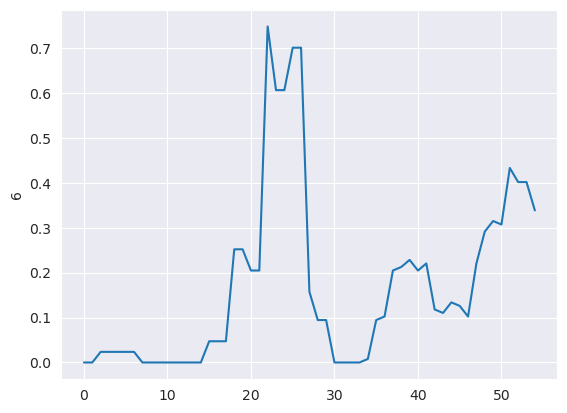

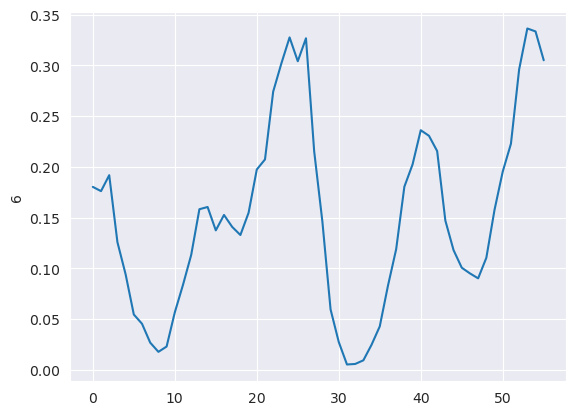

In [90]:
target_taxa = 6

sns.lineplot(y_test_df[target_taxa])
plt.show()

sns.lineplot(y_pred_df[target_taxa])
plt.show()

In [37]:
def calculate_errors(y_pred_df, y_test_df):
    
    errors_df = []
    for col in y_pred_df.columns:
        errors = abs((y_test_df[col] - y_pred_df[col] ) / (y_test_df[col] + 1e-10))
        errors_df.append(errors)
        
    errors_df = pd.concat(errors_df, axis=1)
    
    return errors_df

In [29]:
errors_df = calculate_errors(y_pred_df, y_test_df)
errors_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,0.872727,0.436364,208307152.241704,14255207.541271,0.745455,138517288.115715,0.672727,0.981818,50428089.701561,1.000000,...,62850602.031063,115.079641,89104805.210122,0.727273,0.854545,0.763636,0.781818,0.472727,0.727273,26640666.115484
std,0.336350,0.500505,417193428.710038,45057858.840776,0.439620,284576768.957972,0.473542,0.134840,117412935.410429,0.000000,...,138234901.149572,411.517099,156273399.065626,0.449467,0.355808,0.428764,0.416818,0.503857,0.449467,138906757.554751
min,0.000000,0.000000,0.013648,0.000000,0.000000,0.002074,0.000000,0.000000,0.035230,1.000000,...,0.095782,0.026056,0.084857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027858
25%,1.000000,0.000000,0.377729,0.857105,0.500000,0.315011,0.000000,1.000000,0.649007,1.000000,...,0.350331,0.418961,0.587073,0.000000,1.000000,0.999999,0.999999,0.000000,0.000000,0.483225
50%,1.000000,0.000000,0.570800,0.973462,1.000000,0.611033,1.000000,1.000000,13.268141,1.000000,...,0.750341,0.607747,1.085245,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.754487
75%,1.000000,1.000000,4.626445,0.998212,1.000000,8.515292,1.000000,1.000000,61.040925,1.000000,...,64559697.639197,0.804055,120002720.504999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.979972
max,1.000000,1.000000,1563159972.429276,199822783.470154,1.000000,1061886847.019196,1.000000,1.000000,442900173.366070,1.000000,...,632565990.090370,2095.684985,544942095.875740,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,793899297.714233
